# STAT 542 — Coding Assignment 1

### YU-WEI LAI
### UIN: 677679455
#### 2021.09.12
---- 
_Python is the main coding language used in the script._
### **Import Libraries and Set Seed**

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import classification_report, confusion_matrix

random.seed(9455)
np.random.seed(9455)


### **Data Generation**
##### Set Default Value for data centers

In [2]:
### ---------------------------- ###
### Data Generating
### ---------------------------- ###

p = 2;      
csize = 10;     # number of centers
sigma = 1;      # sd for generating the centers

# Create centers for generating dataset
m1 = np.random.normal(size = (csize, p)) * sigma \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * sigma \
     + np.concatenate([np.array([[0, 1]] * csize)])

##### Function for Generating Data

In [3]:
# ---------------
# Generate Data
def generate_sim_data(sim_params):
    p = sim_params['p']
    s = sim_params['s']
    n = sim_params['n']
    N = sim_params['N'] 
    m1 = sim_params['m1']
    m0 = sim_params['m0']
    csize = sim_params['csize']
    
    id1 = np.random.randint(csize, size = n)
    id0 = np.random.randint(csize, size = n)
    traindata = np.random.normal(size = (2 * n, p)) * s + np.concatenate([m1[id1,:], m0[id0,:]])
    y_train = np.concatenate(([1]*n, [0]*n))
    shuffle_row_id = np.random.randint(n)
    
    id1 = np.random.randint(csize, size = N)
    id0 = np.random.randint(csize, size = N)
    testdata = np.random.normal(size = (2 * N, p)) * s + np.concatenate([m1[id1,:], m0[id0,:]])
    y_test = np.concatenate(([1]*N, [0]*N))
    
    # Return the training/test data along with labels
    return traindata, y_train, testdata, y_test

##### Use the function above to generate data

In [4]:
sim_params = dict({
    'csize': 10,      # number of centers
    'p': 2,           # dimension
    's': math.sqrt(1/5),  # standard deviation for generating data
    'n': 100,         # training size per class
    'N': 5000,        # test size per class
    'm0': m0,         # 10 centers for class 0
    'm1': m1         # 10 centers for class 1
    })

traindata, y_train, testdata, y_test = generate_sim_data(sim_params)
n = sim_params['n']
N = sim_params['N']

### **Visualize the Generated Data**

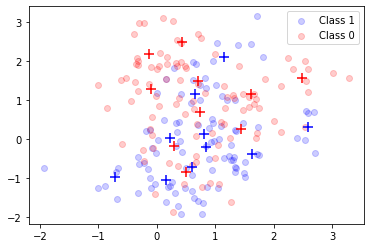

In [5]:
# ---------------
# Visulize the Generated Data
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

----
## **Part 1. KNN**
 ### **1. Write your own KNN code without using any packages**
 ### **2. Explain how you handle distance ties and voting ties;**

In [6]:
# ---------------
# ---------------
# Part 1. KNN

# Write your own KNN code without using any packages;
# Explain how you handle distance ties and voting ties;
# Test your code with mydata when K = 1, 3, 5; compare your results with the ones from the R command knn.
# Calculate Euclidean distance for two points

def get_distance(p, q):
    d = 0
    d = (p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2
    return math.sqrt(d)

The function `get_distance()` is used for calculating the Euclidean distance between two points. Pass two two-dimensional arrays, p and q, to the function, and the function will return the distance between p and q as a float.

In [7]:

def myknn(testdata, traindata, y_train, k=1):
    y_pred = list()

    # Breaking Voting Tie
    def voting_breaker(d_list):
        c_list = [x[0] for x in d_list]
        uniuqe_c = list(set(c_list))

        # Calculate total distance for breaking the voting tie
        total_dist = list()
        for c in uniuqe_c:
            total_dist.append(sum([x[1] for x in d_list if x[0] == c]))
        
        # Compare total distance and return the smallest result
        if total_dist[0] > total_dist[1]:
            return uniuqe_c[1]
        elif total_dist[0] < total_dist[1]:
            return uniuqe_c[0]
        elif total_dist[0] == total_dist[1]:
            return random.choice(uniuqe_c)

    # Get predict for a test point
    def get_predit(test, train_set, y_train, k=1):
        # d_list: list contains [0]-train_label, [1]-distance
        d_list = list()
        for i, p in enumerate(train_set):
            d_list.append([y_train[i], get_distance(p, test)])

        # ------------ #
        # Find the k nearest points for each point
        d_list.sort(key = lambda x: x[1])
        result_list = d_list[0:k]

        # --- Distance ties
        # Included all of them --- automatically add k
        add_k = k
        while d_list[add_k][1] > (result_list[-1][1] - (10**-6)) \
            and d_list[add_k][1] < (result_list[-1][1] + (10**-6)):
            result_list.append(d_list[add_k])
            add_k += 1
            if add_k >= len(d_list):
                break

        # ------------ #
        # Deside which category for each point
        # c: category
        c_list = [x[0] for x in result_list]
        uniuqe_c = list(set(c_list))

        c_result = ''
        result_count = -1
        for c in uniuqe_c:
            count = c_list.count(c)
            if count > result_count:
                c_result = c
                result_count = count

            # --- Voting ties
            elif count == result_count:
                c_result = voting_breaker(result_list)
        return c_result

    # ------------ #
    for x in testdata:
        y_pred.append(get_predit(x, traindata, y_train, k=k))
    return y_pred

The function `myknn()` is the main process to categorize datasets. In the function, there are two sub-functions, which are `voting_breaker()` and `get_predit()`. The former is used for breaking voting ties, and the latter is used for getting a prediction for one data point. In `get_predit()`, it required a training dataset, training y-labels, a testing point, and the k-value. The function will calculate distances for the point to each point in the training set by using the function `get_distance()` we already defined and select the closest k points. By those k-points’ categories, the function will decide the category for the point by selecting the most frequent category. If the frequency of k-points is the same, and then it goes into a voting tie. It will use the function `voting_breaker()` to break the tie.
The function `myknn()` will use the function `get_predit()` for each point in the testing set, which size is N in our process. After the loop for prediction, the function will return the result of all category predictions as a one-dimensional list which length is also the same as the length of the testing set (N).


#### Breaking “Distance Ties”
In the sub-function `get_predit()`, if there are other distances which are no different from the farthest selected K by $10^{-6}$, the function will automatically add those points into the selected K-list.



#### Breaking “Voting Ties”
The function `voting_breaker()` is used for breaking voting ties. The method for deciding the final category is by calculating the total distance for both categories. For example, when K=4, there are both two selected points for category one and category two. If the sum of the distance from two points of category one to the test point is less than the sum of category two, the function will return that category one is the result of the test point.



### **3. Test your code with mydata when K = 1, 3, 5; compare your results with the ones from the R command KNN.**
#### When K = 1:
- Python’s Result

In [8]:
# Compare with pre-defined package
# K = 1
# Python KNN Result
pyknn = knn(n_neighbors = 1)
pyknn.fit(traindata, y_train)
y_pred = pyknn.predict(testdata)
print(confusion_matrix(y_test, y_pred))

[[3263 1737]
 [1788 3212]]


- My Result

In [9]:

# My KNN Results
y_pred = myknn(testdata, traindata, y_train, k=1)
print(confusion_matrix(y_test, y_pred))

[[3263 1737]
 [1788 3212]]


#### When K = 3:
- Python’s Result

In [10]:
# K = 3
# Python KNN Result
pyknn = knn(n_neighbors = 3)
pyknn.fit(traindata, y_train)
y_pred = pyknn.predict(testdata)
print(confusion_matrix(y_test, y_pred))

[[3251 1749]
 [1457 3543]]


- My Result

In [11]:
# My KNN Results
y_pred = myknn(testdata, traindata, y_train, k=3)
print(confusion_matrix(y_test, y_pred))

[[3251 1749]
 [1457 3543]]


#### When K = 5:
- Python’s Result

In [12]:
# K = 5
# Python KNN Result
pyknn = knn(n_neighbors = 5)
pyknn.fit(traindata, y_train)
y_pred = pyknn.predict(testdata)
print(confusion_matrix(y_test, y_pred))

[[3179 1821]
 [1283 3717]]


- My Result

In [13]:
# My KNN Results
y_pred = myknn(testdata, traindata, y_train, k=5)
print(confusion_matrix(y_test, y_pred))

[[3179 1821]
 [1283 3717]]


The KNN package from Scikit-learn is used as prediction benchmark, and the confusion matrix is used for displaying the result. From testing examples above, we can find out that the results of self-defined function and the Python’s package are the same.

----
## **Part II. Repeat Process for Training and Testing.**
In this part, four prediction methods are defined as functions. All of these functions required training data, training labels, testing data, and testing labels. Functions will return a ‘result’ dictionary with training error and testing error recorded, while KNN method will also record selected best K value and cross validation selecting criteria.
#### Linear Regression

In [14]:
# Part II
# In the second part of this assignment, you are asked to use the same set of centers m1 and m0, and repeat the data generating process using generate_sim_data 50 times. For each dataset, calculate the training and test errors (the averaged 0/1 error) for each the following four procedures:

# Linear regression with cut-off value 0.5,
# quadratic regression with cut-off value 0.5,
# KNN classification with K chosen by 10-fold cross-validation, and
# the Bayes rule (assume your know the values of 20 centers and s).

# ---------------
# ---------------

# Linear Regression
def linear_regression(traindata, y_train, testdata, y_test, n, N):
    linear_model = lm.LinearRegression()
    linear_model.fit(traindata, y_train)

    y_train_pred_LS = linear_model.predict(traindata)
    y_test_pred_LS = linear_model.predict(testdata)
    # print('R-square: ', linear_model.score(traindata, y_train))
    # print('MSE: ', np.mean((linear_model.predict(traindata) - y_train) ** 2))

    y_train_pred_LS = [1 if i >= 0.5 else 0 for i in y_train_pred_LS]
    y_test_pred_LS = [1 if i >= 0.5 else 0 for i in y_test_pred_LS]

    result = dict()
    result['train_error'] = sum(y_train != y_train_pred_LS) / float(2*n)
    result['test_error'] = sum(y_test != y_test_pred_LS) / float(2*N)
    # print('LM: ', result['train_error'], result['test_error'])

    return result


In the part of linear regression, the linear method from Scikit-learn is used. First, the function will fit a linear model. With the model, then it will get prediction for training data and testing data with 0.5 cut-off value. Finally, by comparing predicted results with actual labels, the function will calculate the training error and the testing error.

#### Quadratic Regression

In [15]:
# Quadratic Regression
def quad_regression(traindata, y_train, testdata, y_test, n, N):
    train_quad = np.array([np.array([x[0], x[0]**2, x[1], x[1]**2, x[0]*x[1]]) for x in traindata])
    test_quad = np.array([np.array([x[0], x[0]**2, x[1], x[1]**2, x[0]*x[1]]) for x in testdata])

    quad_model = lm.LinearRegression()
    quad_model.fit(train_quad, y_train)

    # print('R-square: ', quad_model.score(train_quad, y_train))
    # print('MSE: ', np.mean((quad_model.predict(train_quad) - y_train) ** 2))

    y_train_pred_quad = quad_model.predict(train_quad)
    y_test_pred_quad = quad_model.predict(test_quad)

    y_train_pred_quad = [1 if i >= 0.5 else 0 for i in y_train_pred_quad]
    y_test_pred_quad = [1 if i >= 0.5 else 0 for i in y_test_pred_quad]

    result = dict()
    result['train_error'] = sum(y_train != y_train_pred_quad) / float(2*n)
    result['test_error'] = sum(y_test != y_test_pred_quad) / float(2*N)
    # print('Quad Regression: ', result['train_error'], result['test_error'])

    return result

In the part of quadratic regression, the function will first create quadratic terms and interaction terms for the data. Then it will also fit the linear model from Scikit-learn package with training data. Thereafter, similar process with the linear method, we get prediction by using the transformed data in the model. Finally, the function will return the training error and the testing error stored in the ‘result’ dictionary.

#### KNN with 10-fold Cross Validation

In [16]:
# KNN with 10-fold cross-validation
def cv_knn_ave_error_rate(traindata, y_train, fold_num=10, k=1):
    n = len(traindata)
    fold_size = int(n//fold_num)
    pyknn = knn(n_neighbors = k)

    my_index = list(range(0, n))
    random.shuffle(my_index) # random suffle will in place the original list

    error = 0
    for run_id in range(1, fold_num + 1):
        if run_id == fold_num:
            fold_index = list(range((run_id-1)*fold_size, n))
        else:
            fold_index = list(range((run_id-1)*fold_size, run_id*fold_size))
        
        test_set_index = [my_index[i] for i in fold_index]
        train_set_index = [my_index[i] for i in range(0, len(my_index)) if i not in fold_index]
        
        train_x = [traindata[i] for i in train_set_index]
        train_y = [y_train[i] for i in train_set_index]
        test_x = [traindata[i] for i in test_set_index]
        test_y = [y_train[i] for i in test_set_index]
        
        pyknn.fit(train_x, train_y) # Use pre-defined knn method
        predict_y = pyknn.predict(test_x)
        
        # error = error + sum(predict_y != test_y)
        for i, x in enumerate(predict_y):
            if x != test_y[i]:
                error = error + 1

    error = error / n
    return error

def cv_knn(traindata, y_train, testdata, y_test, n, N, fold_num):
    n = len(traindata)
    fold_size = int(n//fold_num)  
    k_vector = list(range(1, (len(traindata) - fold_size), 1))
    cvErrorRates = list()
    for k in k_vector:
        cvErrorRates.append(cv_knn_ave_error_rate(traindata, y_train, fold_num, k))
    
    result = dict()
    # result['best_k'] = max(k_vector[cvErrorRates == min(cvErrorRates)])
    
    result['best_k'] = max([k_vector[i] for i, error in enumerate(cvErrorRates) if error == min(cvErrorRates)])
    result['cv_error'] = min(cvErrorRates)
    # result['cv_error'] = cvErrorRates[k_vector == result['best_k']]

    pyknn = knn(n_neighbors = result['best_k'])
    pyknn.fit(traindata, y_train)
    y_train_pred = pyknn.predict(traindata)
    y_test_pred = pyknn.predict(testdata)
    result['train_error'] = sum(y_train != y_train_pred) / float(n)
    result['test_error'] = sum(y_test != y_test_pred) / float(2*N)
    # print('CV KNN:', result['train_error'], result['test_error'])

    return result

The function `cv_knn_ave_error_rate` is used for dividing training into given folds and calculate the average error rate. This function required the k-value setting. First, a random index list is created for not training folds with original orders. For the given folds, it will divide into two groups by the fold size, and fit the KNN with the largest set. Then we can get prediction and calculate error per time. The method will continuously do by given fold times.
In the main process `cv_knn` it will use the function `cv_knn_ave_error_rate` to get cross validation error for each K. With the error toward each K value, the function will select the K value with the lowest error rate. If the error rates are the same, the function will choose the larger K due to less complexity of the model. With the K value, the function will train a final model, and make prediction with training set and testing set. Compared with original category labels, the function will calculate and return the training error and the testing error.

#### Bayes Rule

In [17]:
# Bayes rule
def bayes_rule(traindata, y_train, testdata, y_test, n, N, sigma, m1, m0):
    def mixnorm(x, centers0=m0, centers1=m1, sigma=sigma):
        ## return the density ratio for a point x, where each density is a mixture of normal with multiple components            
        d1 = sum([math.exp(get_distance(m, x)**2/(-2 * sigma ** 2)) for m in centers1])
        d0 = sum([math.exp(get_distance(m, x)**2/(-2 * sigma ** 2)) for m in centers0])
    
        return (d1 / d0)

    y_test_pred = [mixnorm(x) > 1 for x in testdata]
    y_train_pred = [mixnorm(x) > 1 for x in traindata]

    result = dict()
    result['train_error'] = sum(y_train !=  y_train_pred) / float(2*n)
    result['test_error'] = sum(y_test !=  y_test_pred) / float(2*N)
    # print('Bayes:', result['train_error'], result['test_error'])

    return result

The sub-function `mixnorm()` is used for calculating the density ratio for a point, it follows the formula:

$\frac{\sum_{j=1}^{10}exp\{-\frac{1}{2s^2}||m_{1j}-x||^2\}}{\sum_{j=1}^{10}exp\{-\frac{1}{2s^2}||m_{0j}-x||^2\}}$

With the density ratio, the function will categorize each points in both training data set and testing data set. Then it will calculate and return the training error and testing error.

### Repeat 50 times for the methods above
Use the function `linear_regression()`, `quad_regression()`, `cv_knn()`, and `bayes_rule()` defined above for 50 times. Each time, the program will record the result in the dictionaries regarding methods. Keys for dictionaries will be the round that run methods, and values will be another dictionary, which is described above.

In [18]:
# Try 50 times and record their performance
lm_result = dict()
quad_result = dict()
cv_knn_result = dict()
bayes_result = dict()

for i in range(50):
    # print(i, ':\nTrain Error | Test Error')
    traindata, y_train, testdata, y_test = generate_sim_data(sim_params)

    lm_result[i] = linear_regression(traindata, y_train, testdata, y_test, n, N)
    quad_result[i] = quad_regression(traindata, y_train, testdata, y_test, n, N)
    cv_knn_result[i] = cv_knn(traindata, y_train, testdata, y_test, n, N, fold_num=10)
    bayes_result[i] = bayes_rule(traindata, y_train, testdata, y_test, n, N, sigma, m1, m0)

### Plot the results: Training Error and Test Error
Since we stored the results in four dictionaries, we have to extract training error and testing error from dictionaries. Therefore, the function `extrat_error()` is defined. The function will extract several dictionaries’ training error and testing error. After we recorded those error in lists, we can visualize the error by box plot defined by Matplotlib.(Matplotlib: Group Boxplots, 2013)

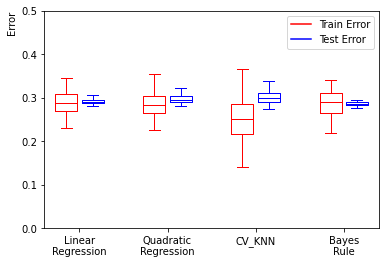

In [19]:
# Plot the Result
# Reference: https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

def extrat_error(*args):
    data_train_error = list()
    data_test_error = list()
    for arg in args:
        data_train_error.append([x['train_error'] for x in arg.values()])
        data_test_error.append([x['test_error'] for x in arg.values()])

    return data_train_error, data_test_error

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

data_train_error, data_test_error = extrat_error(lm_result, quad_result, cv_knn_result, bayes_result)
ticks = ['Linear\nRegression', 'Quadratic\nRegression', 'CV_KNN', 'Bayes\nRule']

plt.figure()
bpl = plt.boxplot(data_train_error, positions=np.array(range(len(data_train_error)))*2 - 0.3, sym='')
bpr = plt.boxplot(data_test_error, positions=np.array(range(len(data_test_error)))*2 + 0.3, sym='')

# Set bar color
set_box_color(bpl, 'red')
set_box_color(bpr, 'blue')

# Create a legend
plt.plot([], c='red', label='Train Error')
plt.plot([], c='blue', label='Test Error')
plt.legend()

# Adjust range for x and y
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.ylim(0, 0.5)
plt.ylabel('Error', loc='top')
plt.show()

### Report the mean and standard error for the chosen K values

In [20]:
# Mean and Standard Error for Chosen K from CV KNN
chosen_k = [x['best_k'] for x in cv_knn_result.values()]
print('Mean: ', np.mean(chosen_k))
print('Standard Error: ', np.std(chosen_k) / np.sqrt(np.size(chosen_k)))

Mean:  56.12
Standard Error:  7.390785614533816


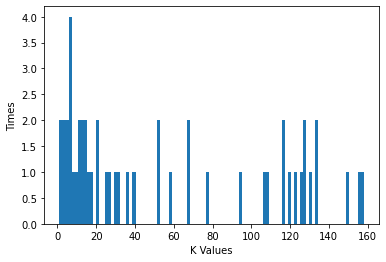

In [21]:
plt.hist(chosen_k, 100)
plt.xlabel('K Values')
plt.ylabel('Times')
plt.show()

## Reference
- IS 542: (PSL) Coding Assignment 1
- IS 542: Week 1 Lecture Notes and Coding Examples
- Matplotlib: Group box plots. (2013, May 16). Stack Overflow. https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots